In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("→ Added to sys.path:", project_root)
print("→ cwd is:", os.getcwd())

from environments.realistic_env    import realisticAUVEnv
from agents.td3_agent              import TD3Agent
from utils.rl_utils                import *

→ Added to sys.path: /Users/eirikvarnes/code/auv-rl-project
→ cwd is: /Users/eirikvarnes/code/auv-rl-project/notebooks
pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Static Environment (No Physics)

In [2]:
continuous_env = realisticAUVEnv(
    # ─── Map & observation ─────────────────────────────────────────
    grid_size          = (200, 200),
    resolution         = 0.05,
    docks              = 1,
    dock_radius        = 0.5,
    use_history        = True,
    history_length     = 4,
    window_size        = (800, 600),

    # ─── Physics ───────────────────────────────────────────────────
    mass               = 1.0,
    drag_coef          = 0.5,
    dt                 = 0.1,
    use_drag           = False,   # ignore drag forces
    use_inertia        = False,   # kinematic (no Newtonian integration)
    current_params     = None,    # no ocean current

    # ─── Action space ─────────────────────────────────────────────
    discrete_actions   = False,

    # ─── Reward scheme ────────────────────────────────────────────
    use_continuous_reward   = True,
    step_penalty            = -1.0,   # per-step cost in discrete mode
    slow_step_penalty       = 0.05,   # per-step cost in continuous mode
    action_penalty_coeff    = 0.1,    # cost ∝ |v|+|lat|+|ω|
    progress_coeff          = 8.0,    # reward ∝ distance closed
    collision_penalty       = -0.1,   # penalty on collision
    turn_penalty_coeff      = 0.1,    # cost ∝ |ω| each step
    dock_reward             = 100.0,  # terminal bonus on docking
)

# **Simple TD3 Agent**

TD3: 100%|██████████| 5000/5000 [2:06:55<00:00,  1.52s/it, Reward=-1101.69]  


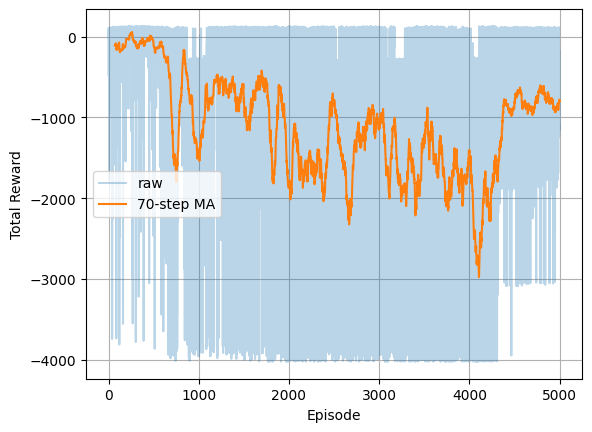

In [ ]:
td3_agent = TD3Agent(continuous_env)

rewards = train_td3(continuous_env, td3_agent, episodes=200, max_steps=1000)

# plot the learning curve
plot_rewards(rewards, window=70)

In [9]:
sr, avg_steps = evaluate_agent(continuous_env, td3_agent, episodes=1000, max_steps=2000)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")

Success rate: 69.0%, Avg steps: 769.4


In [10]:
record_headless(continuous_env, td3_agent, out_path="../gifs/td3_run.gif", max_steps=200, fps=10)

Headless recording saved to ../gifs/td3_run.gif


# **Enhanced TD3 Agent**

In [3]:
enhanced_td3_agent = TD3Agent(
    continuous_env,
    hidden_dims    = [128, 128, 64],  
    actor_lr       = 5e-4,
    critic_lr      = 5e-4,
    gamma          = 0.99,
    tau            = 0.006,
    buffer_size    = 10_000,
    batch_size     = 128,
    policy_noise   = 0.2,
    noise_clip     = 0.4,
    policy_freq    = 2,
)

rewards = train_td3(continuous_env, enhanced_td3_agent, episodes=2000, max_steps=1000)

# plot the learning curve
plot_rewards(rewards, window=70)

TD3:  40%|███▉      | 794/2000 [17:09<26:03,  1.30s/it, Reward=-179.24]  


KeyboardInterrupt: 

In [ ]:
sr, avg_steps = evaluate_agent(continuous_env, enhanced_td3_agent, episodes=1000, max_steps=1000)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")

Success rate: 72.3%, Avg steps: 213.2


In [ ]:
record_headless(continuous_env, enhanced_td3_agent, out_path="../gifs/enhanced_td3_run.gif", max_steps=1000, fps=10)

Headless recording saved to ../gifs/enhanced_td3_run.gif


# **Random map**

In [ ]:
random_continuous_env = realisticAUVEnv(
    # ─── Map & observation ─────────────────────────────────────────
    grid_size          = (200, 200),
    resolution         = 0.05,
    docks              = 1,
    dock_radius        = 0.7,
    use_history        = True,
    history_length     = 15,
    window_size        = (800, 600),

    # ─── Physics ───────────────────────────────────────────────────
    mass               = 1.0,
    drag_coef          = 0.5,
    dt                 = 0.1,
    use_drag           = False,   # ignore drag forces
    use_inertia        = False,   # kinematic (no Newtonian integration)
    current_params     = None,    # no ocean current

    # ─── Action space ─────────────────────────────────────────────
    discrete_actions   = False,

    # ─── Reward scheme ────────────────────────────────────────────
    use_continuous_reward   = True,
    step_penalty            = -1.0,   # per-step cost in discrete mode
    slow_step_penalty       = 0.02,   # per-step cost in continuous mode
    action_penalty_coeff    = 0.05,    # cost ∝ |v|+|lat|+|ω|
    turn_penalty_coeff      = 0.05,    # cost ∝ |ω| each step
    dock_reward             = 500.0,  # terminal bonus on docking

    wall_thresh             = 0.06,    # distance to the wall
    wall_penalty_coeff      = 0.1,    # cost ∝ distance to the wall
    collision_penalty       = -0.06,   # penalty on collision
    progress_coeff          = 4.0,    # reward ∝ distance closed

    v_limit= 0.5,    # max speed
    omega_limit= 0.5,  # max angular speed

    # ─── Map generation ──────────────────────────────────────────
    random_map              = True,    # generate a random map
    map_fill_prob           = 0.05,  # probability of a cell being filled with an obstacle
    smooth_steps            = 14,      # number of smoothing steps to apply to the map
    birth_limit             = 3,       # number of cells that need to be filled for a cell to be born
    death_limit             = 2       # number of cells that need to be empty for a cell to die
)

TD3: 100%|██████████| 500/500 [10:48<00:00,  1.30s/it, Reward=-371.84]


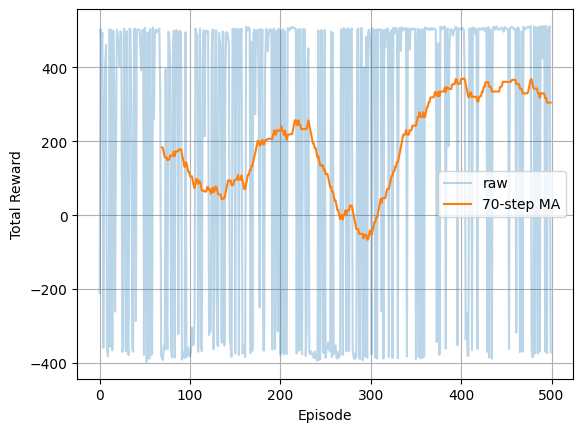

In [19]:
random_td3_agent = TD3Agent(random_continuous_env)

rewards = train_td3(random_continuous_env, random_td3_agent, episodes=500, max_steps=2000)

# plot the learning curve
plot_rewards(rewards, window=70)

In [20]:
record_headless(random_continuous_env, random_td3_agent, out_path="../gifs/random_td3_run.gif", max_steps=1000, fps=10)

Headless recording saved to ../gifs/random_td3_run.gif


In [ ]:
sr, avg_steps = evaluate_agent(random_continuous_env, random_td3_agent, episodes=100, max_steps=1000)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")

Success rate: 85.0%, Avg steps: 61.2


In [2]:
random_enhanced_td3_agent = TD3Agent(
    random_continuous_env,
    hidden_dims    = [256, 256, 128],  
    actor_lr       = 3e-4,
    critic_lr      = 3e-4,
    gamma          = 0.99,
    tau            = 0.006,
    buffer_size    = 200_000,
    batch_size     = 128,
    policy_noise   = 0.2,
    noise_clip     = 0.4,
    policy_freq    = 2,
)

rewards = train_td3(random_continuous_env, random_enhanced_td3_agent, episodes=400, max_steps=2000)

# plot the learning curve
plot_rewards(rewards, window=70)

NameError: name 'random_continuous_env' is not defined

In [5]:
sr, avg_steps = evaluate_agent(random_continuous_env, random_enhanced_td3_agent, episodes=100, max_steps=1000)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")

Success rate: 94.0%, Avg steps: 70.8


In [11]:
record_headless(random_continuous_env, random_enhanced_td3_agent, out_path="../gifs/random_enhanced_td3_run.gif", max_steps=1000, fps=10)

Headless recording saved to ../gifs/random_enhanced_td3_run.gif


# **Random Environment With Intertia**

In [ ]:
current_params={
        'strength': 0.01,               # speed of current in m/s
        'direction': np.pi / 4,        # 45° angle
        'period': 10.0                 # sinusoidal oscillation
    }

physics_random_continuous_env = realisticAUVEnv(
    # ─── Map & observation ─────────────────────────────────────────
    grid_size          = (200, 200),
    resolution         = 0.05,
    docks              = 1,
    dock_radius        = 0.7,
    use_history        = True,
    history_length     = 25,
    window_size        = (800, 600),

    # ─── Physics ───────────────────────────────────────────────────
    mass               = 1.0,
    drag_coef          = 0.1,
    dt                 = 0.1,
    use_drag           = True,   # ignore drag forces
    use_inertia        = True,   # kinematic (no Newtonian integration)
    current_params     = current_params,    
    

    # ─── Action space ─────────────────────────────────────────────
    discrete_actions   = False,

    # ─── Reward scheme ────────────────────────────────────────────
    use_continuous_reward   = True,
    step_penalty            = -1.0,   # per-step cost in discrete mode
    slow_step_penalty       = 0.02,   # per-step cost in continuous mode
    action_penalty_coeff    = 0.05,    # cost ∝ |v|+|lat|+|ω|
    turn_penalty_coeff      = 0.05,    # cost ∝ |ω| each step
    dock_reward             = 500.0,  # terminal bonus on docking

    wall_thresh             = 0.06,    # distance to the wall
    wall_penalty_coeff      = 0.1,    # cost ∝ distance to the wall
    collision_penalty       = -0.06,   # penalty on collision
    progress_coeff          = 4.0,    # reward ∝ distance closed

    v_limit= 0.3,    # max speed
    omega_limit= 0.3,  # max angular speed

    # ─── Map generation ──────────────────────────────────────────
    random_map              = True,    # generate a random map
    map_fill_prob           = 0.05,  # probability of a cell being filled with an obstacle
    smooth_steps            = 14,      # number of smoothing steps to apply to the map
    birth_limit             = 3,       # number of cells that need to be filled for a cell to be born
    death_limit             = 2       # number of cells that need to be empty for a cell to die
)

In [18]:
physics_random_enhanced_td3_agent = TD3Agent(
    physics_random_continuous_env,
    hidden_dims    = [256, 256, 128],  
    actor_lr       = 3e-4,
    critic_lr      = 3e-4,
    gamma          = 0.99,
    tau            = 0.006,
    buffer_size    = 200_000,
    batch_size     = 128,
    policy_noise   = 0.2,
    noise_clip     = 0.4,
    policy_freq    = 2,
)

TD3: 100%|██████████| 10/10 [01:36<00:00,  9.69s/it, Reward=-286.92]


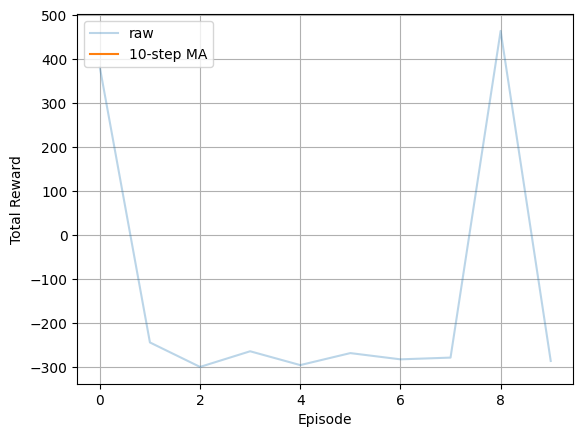

In [19]:
rewards = train_td3(physics_random_continuous_env, physics_random_enhanced_td3_agent, episodes=10, max_steps=2000)

# plot the learning curve
plot_rewards(rewards, window=10)

In [20]:
record_headless(physics_random_continuous_env, physics_random_enhanced_td3_agent, out_path="../gifs/physics_random_enhanced_td3_run.gif", max_steps=1000, fps=10)

Headless recording saved to ../gifs/physics_random_enhanced_td3_run.gif


In [ ]:
sr, avg_steps = evaluate_agent(physics_random_continuous_env, physics_random_enhanced_td3_agent, episodes=100, max_steps=1000)
print(f"Success rate: {sr*100:.1f}%, Avg steps: {avg_steps:.1f}")